In [ ]:
!unzip './mitbih_train.csv.zip'

Archive:  ./mitbih_train.csv.zip
  inflating: mitbih_train.csv        
  inflating: __MACOSX/._mitbih_train.csv  


In [ ]:
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.utils import to_categorical

""" First Dataset Exploration """

# Loading MITBIH data
df_bih1 = pd.read_csv('./mitbih_train.csv', header=None)



df_bih1[187]=df_bih1[187].astype(int)
equilibre=df_bih1[187].value_counts()
print(equilibre)

# Rebalancing Dataset
from sklearn.utils import resample
df_1=df_bih1[df_bih1[187]==1]
df_2=df_bih1[df_bih1[187]==2]
df_3=df_bih1[df_bih1[187]==3]
df_4=df_bih1[df_bih1[187]==4]
df_0=(df_bih1[df_bih1[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)


train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
equilibre=train_df[187].value_counts()
print(equilibre)

# Dataset is rebalanced here
train_df[187].value_counts()


X = train_df.values[:,:-1]
y = train_df.values[:,-1]
y = to_categorical(y)


TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


FileNotFoundError: ignored

In [ ]:
# -*- coding: utf-8 -*-
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM,Bidirectional, GRU
from keras import optimizers,regularizers



X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

def lstm_net():
  im_shape=(X_train.shape[1],1)
  model = Sequential()
  model.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=im_shape))
  model.add(Bidirectional(LSTM(64, return_sequences=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(5, activation='sigmoid'))
  model.add(Flatten())
  model.add(Dense(5, activation='sigmoid'))
  adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy']) 
  return model

model = lstm_net()
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
history=model.fit(X_train, y_train,epochs=10,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, input_shape=(187, 1), kernel_regularizer=<keras.reg...)`



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_regularizer=<keras.reg...)`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 70000 samples, validate on 30000 samples
Epoch 1/10





70000/70000 [==============================] - 687s 10ms/step - loss: 0.5679 - acc: 0.8239 - val_loss: 0.3851 - val_acc: 0.8725
Epoch 2/10
70000/70000 [==============================] - 688s 10ms/step - loss: 0.3368 - acc: 0.8930 - val_loss: 0.2775 - val_acc: 0.9186
Epoch 3/10
70000/70000 [==============================] - 666s 10ms/step - loss: 0.2780 - acc: 0.9153 - val_loss: 0.2362 - val_acc: 0.9296
Epoch 4/10
70000/70000 [==============================] - 662s 9ms/step - loss: 0.2458 - acc: 0.9273 - val_loss: 0.2208 - val_acc: 0.9389
Epoch 5/10
70000/70000 [==============================] - 676s 10ms/step - loss: 0.2195 - acc: 0.9368 - val_loss: 0.2272 - val_acc: 0.9375
Epoch 6/10
70000/70000 [==============================] - 682s 10ms/step - loss: 0.2007 - acc: 0.9437 - val_loss: 0.1751 - val_acc: 0.9556
Epoch 7/10
7000

In [ ]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [ ]:
model.save('lstm_model.h5')


Accuracy: 96.14%


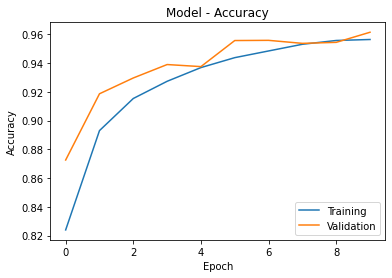

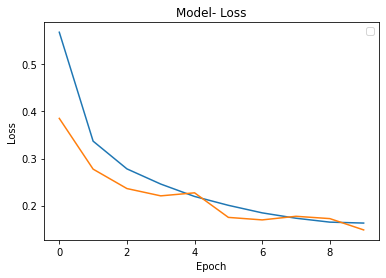

In [ ]:
from sklearn.metrics import confusion_matrix
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    
evaluate_model(history,X_test,y_test,model)



              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5971
           1       0.95      0.96      0.95      5984
           2       0.98      0.95      0.96      6049
           3       0.95      0.99      0.97      5977
           4       1.00      0.99      0.99      6019

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000

Confusion matrix, without normalization


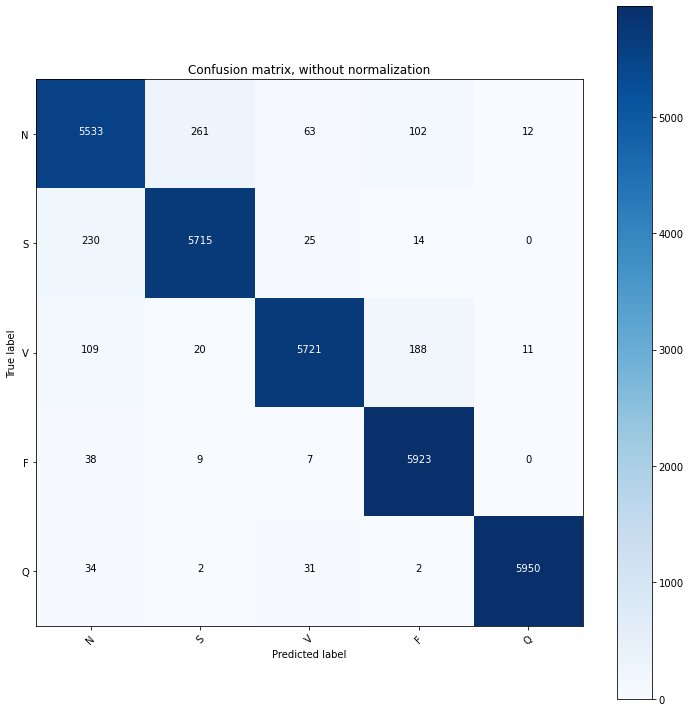

In [ ]:
y_pred = model.predict(X_test, batch_size=1000)
from sklearn.metrics import classification_report
import itertools

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()
